📥 Downloading dataset...


Downloading...
From: https://drive.google.com/uc?id=1s6yaBm2jR70pzDvUa_5hcQodYlVvAS-Z
To: /content/dataset.rar
100%|██████████| 6.83M/6.83M [00:00<00:00, 20.5MB/s]


📦 Extracting dataset...

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from dataset.rar

Creating    ./dataset/final128/Final 128                              OK
Extracting  ./dataset/final128/Final 128/0.jpg                             0%  OK 
Extracting  ./dataset/final128/Final 128/1.jpg                             0%  OK 
Extracting  ./dataset/final128/Final 128/10.jpg                            0%  OK 
Extracting  ./dataset/final128/Final 128/100.jpg                           0%  OK 
Extracting  ./dataset/final128/Final 128/1000.jpg                          0%  OK 
Extracting  ./dataset/final128/Final 128/1001.jpg                          0%  OK 
Extracting  ./dataset/final128/Final 128/1002.jpg                          0%  OK 
Extracting  ./dataset/final128/Final 128/1003.jpg                          0%  OK 
Extracting  ./dataset/final128/Final 128/1004.jpg             

  0%|          | 0/1606 [00:00<?, ?it/s]

✅ Loaded 1606 images.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Streaming output truncated to the last 5000 lines.

📘 Epoch 335/2000
✅ Gen Loss: 2.3179 | Disc Loss: 0.5921

📘 Epoch 336/2000
✅ Gen Loss: 3.1245 | Disc Loss: 0.9199

📘 Epoch 337/2000
✅ Gen Loss: 2.8483 | Disc Loss: 0.5095

📘 Epoch 338/2000
✅ Gen Loss: 2.0452 | Disc Loss: 0.6032

📘 Epoch 339/2000
✅ Gen Loss: 3.6833 | Disc Loss: 0.8528

📘 Epoch 340/2000
✅ Gen Loss: 2.3222 | Disc Loss: 0.5365

📘 Epoch 341/2000
✅ Gen Loss: 3.4142 | Disc Loss: 0.4465

📘 Epoch 342/2000
✅ Gen Loss: 2.4694 | Disc Loss: 0.4993

📘 Epoch 343/2000
✅ Gen Loss: 1.2964 | Disc Loss: 0.8276

📘 Epoch 344/2000
✅ Gen Loss: 2.7513 | Disc Loss: 0.4934

📘 Epoch 345/2000
✅ Gen Loss: 2.8392 | Disc Loss: 0.6014

📘 Epoch 346/2000
✅ Gen Loss: 3.1950 | Disc Loss: 0.4885

📘 Epoch 347/2000
✅ Gen Loss: 3.1240 | Disc Loss: 0.4521

📘 Epoch 348/2000
✅ Gen Loss: 2.0213 | Disc Loss: 0.6738

📘 Epoch 349/2000
✅ Gen Loss: 3.0200 | Disc Loss: 0.4278

📘 Epoch 350/2000
✅ Gen Loss: 3.1983 | Disc Loss: 0.4356

📘 Epoch 351/2000
✅ Gen Loss: 2.4148 

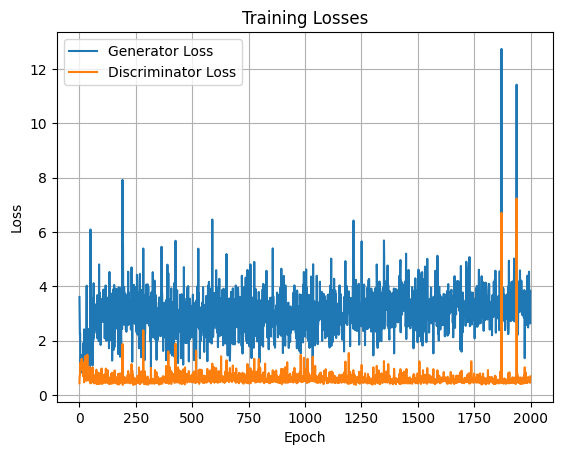

In [1]:
# ✅ Dependencies
!pip install gdown tqdm pillow matplotlib --quiet
!apt-get install -y unrar > /dev/null

# ✅ DCGAN for 128x128 House Dataset
import os, gdown, glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# --- Download & Extract Dataset ---
file_id = '1s6yaBm2jR70pzDvUa_5hcQodYlVvAS-Z'
url = f'https://drive.google.com/uc?id={file_id}'
rar_path = 'dataset.rar'
extract_path = './dataset/final128/Final 128'

print("📥 Downloading dataset...")
gdown.download(url, rar_path, quiet=False, fuzzy=True)
print("📦 Extracting dataset...")
os.makedirs('./dataset/final128', exist_ok=True)
!unrar x -o+ {rar_path} ./dataset/final128
os.remove(rar_path)
print("✅ Dataset ready!")

# --- Parameters ---
IMG_HEIGHT, IMG_WIDTH, CHANNELS = 128, 128, 3
NOISE_DIM = 100
BATCH_SIZE = 32
BUFFER_SIZE = 10000
EPOCHS = 2000
LEARNING_RATE = 1e-4
NUM_EXAMPLES_TO_GENERATE = 16
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

# --- Load Dataset ---
def load_images(path):
    files = glob.glob(os.path.join(path, '*'))
    data = []
    for f in tqdm(files):
        if os.path.isdir(f): continue
        try:
            img = tf.keras.preprocessing.image.load_img(f, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = (img - 127.5) / 127.5
            data.append(img)
        except Exception as e:
            print(f"⚠️ {f}: {e}")
    return np.array(data)

images = load_images(extract_path)
print(f"✅ Loaded {len(images)} images.")
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# --- Models ---
def build_generator():
    return tf.keras.Sequential([
        layers.Dense(16*16*256, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.BatchNormalization(), layers.LeakyReLU(),
        layers.Reshape((16, 16, 256)),
        layers.Conv2DTranspose(128, 4, 2, 'same', use_bias=False), layers.BatchNormalization(), layers.LeakyReLU(),
        layers.Conv2DTranspose(64, 4, 2, 'same', use_bias=False), layers.BatchNormalization(), layers.LeakyReLU(),
        layers.Conv2DTranspose(32, 4, 2, 'same', use_bias=False), layers.BatchNormalization(), layers.LeakyReLU(),
        layers.Conv2DTranspose(CHANNELS, 4, 1, 'same', use_bias=False, activation='tanh')
    ])

def build_discriminator():
    return tf.keras.Sequential([
        layers.Conv2D(64, 4, 2, 'same', input_shape=[IMG_HEIGHT, IMG_WIDTH, CHANNELS]), layers.LeakyReLU(), layers.Dropout(0.3),
        layers.Conv2D(128, 4, 2, 'same'), layers.LeakyReLU(), layers.Dropout(0.3),
        layers.Conv2D(256, 4, 2, 'same'), layers.LeakyReLU(), layers.Dropout(0.3),
        layers.Flatten(), layers.Dense(1, activation='sigmoid')
    ])

generator = build_generator()
discriminator = build_discriminator()
cross_entropy = tf.keras.losses.BinaryCrossentropy()
g_opt = Adam(LEARNING_RATE, beta_1=0.5)
d_opt = Adam(LEARNING_RATE, beta_1=0.5)

# --- Training Step ---
@tf.function
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as gt, tf.GradientTape() as dt:
        fake_images = generator(noise, training=True)
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        d_loss_real = cross_entropy(tf.ones_like(real_output)*0.9, real_output)
        d_loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = d_loss_real + d_loss_fake
    g_grad = gt.gradient(gen_loss, generator.trainable_variables)
    d_grad = dt.gradient(disc_loss, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grad, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grad, discriminator.trainable_variables))
    return gen_loss, disc_loss

# --- Visualization ---
def generate_and_save_images(model, epoch, test_input):
    preds = model(test_input, training=False)
    preds = (preds + 1) / 2.0
    fig = plt.figure(figsize=(4, 4))
    for i in range(preds.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(preds[i])
        plt.axis('off')
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.close()

# --- Training Loop ---
def train(dataset, epochs, start_epoch=0):
    g_losses, d_losses = [], []
    for epoch in range(start_epoch, epochs):
        print(f"\n📘 Epoch {epoch+1}/{epochs}")
        g_loss, d_loss = None, None
        for batch in dataset:
            g_loss, d_loss = train_step(batch)
        if g_loss and d_loss:
            g_losses.append(g_loss.numpy())
            d_losses.append(d_loss.numpy())
            print(f"✅ Gen Loss: {g_loss.numpy():.4f} | Disc Loss: {d_loss.numpy():.4f}")

        if (epoch + 1) % 50 == 0:
            generate_and_save_images(generator, epoch + 1, seed)
        if (epoch + 1) % 200 == 0:
            generator.save_weights(f'generator_epoch_{epoch+1}.weights.h5')
            discriminator.save_weights(f'discriminator_epoch_{epoch+1}.weights.h5')
    generator.save('generator_final.keras')
    discriminator.save('discriminator_final.keras')
    print("\n🎯 Training Done!")

    # --- Plot Losses ---
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.legend()
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# --- Resume From Checkpoint ---
START_FROM = 0  # Change to 500, 1000, etc. to resume
if START_FROM > 0:
    generator.load_weights(f'generator_epoch_{START_FROM}.weights.h5')
    discriminator.load_weights(f'discriminator_epoch_{START_FROM}.weights.h5')

# --- Start Training ---
train(train_dataset, EPOCHS, start_epoch=START_FROM)

In [2]:
# ✅ Final save function for your trained GAN model (Generator & Discriminator)
def save_model_after_training(generator, discriminator):
    import os

    os.makedirs("saved_models", exist_ok=True)  # Create a folder to organize saved models

    # --- Save Weights ---
    generator.save_weights("saved_models/generator_final.weights.h5")
    discriminator.save_weights("saved_models/discriminator_final.weights.h5")

    # --- Save Complete Models ---
    generator.save("saved_models/generator_final.h5", include_optimizer=False)
    discriminator.save("saved_models/discriminator_final.h5", include_optimizer=False)

    print("✅ Generator and Discriminator models have been saved successfully to 'saved_models/' folder.")

# ✅ Run after training is done
save_model_after_training(generator, discriminator)


✅ Generator and Discriminator models have been saved successfully to 'saved_models/' folder.


Button(button_style='success', description='Generate New Image', style=ButtonStyle(), tooltip='Click to genera…

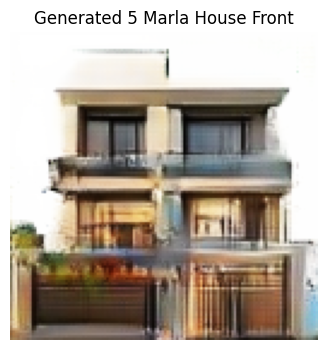

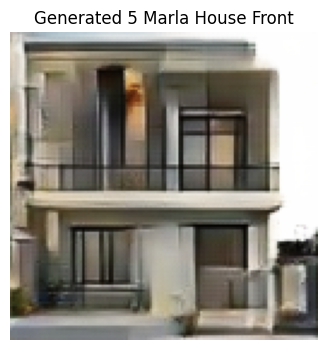

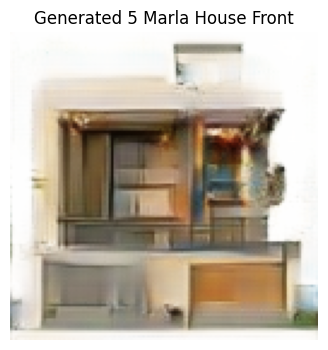

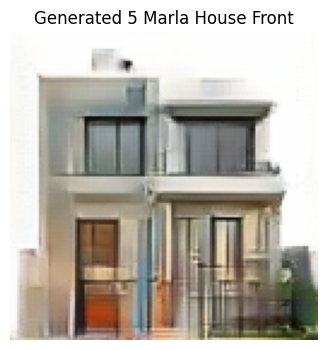

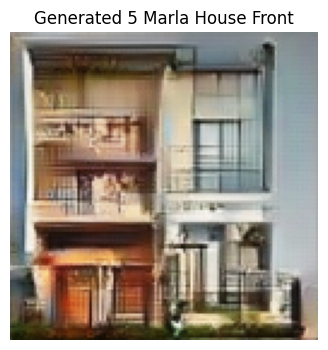

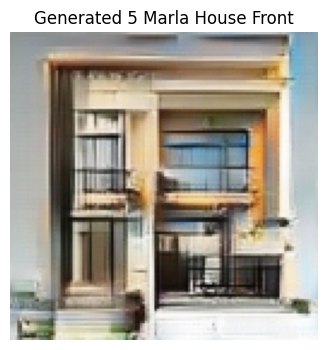

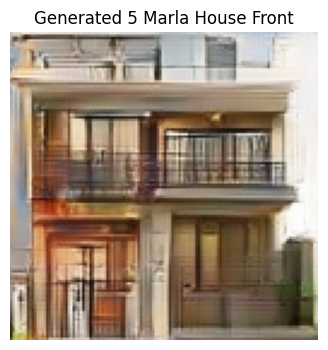

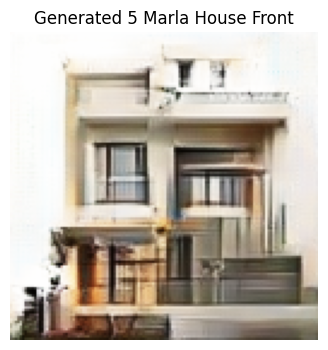

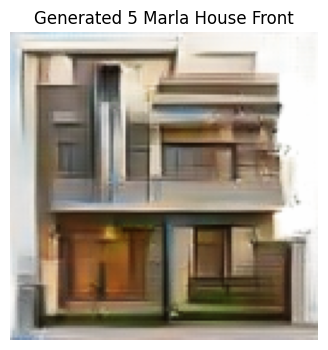

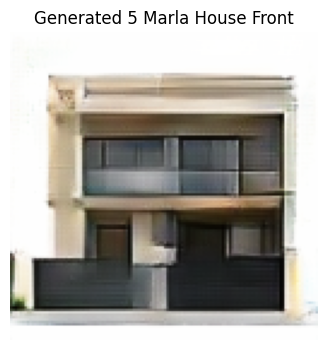

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display
import ipywidgets as widgets

# --- Configuration (Update if needed) ---
IMG_HEIGHT = 128
IMG_WIDTH = 128
CHANNELS = 3
NOISE_DIM = 100  # Same as used during training

# ✅ Load the saved generator model (no need to compile for inference)
generator = tf.keras.models.load_model('saved_models/generator_final.h5', compile=False)

def generate_single_image():
    """
    Generate and display a single front elevation image using the trained generator.
    """
    # Generate random noise vector
    noise = tf.random.normal([1, NOISE_DIM])

    # Generate prediction from noise
    generated_image = generator(noise, training=False)[0]

    # Rescale image from [-1, 1] to [0, 1]
    generated_image = (generated_image + 1) / 2.0

    # Plot the image
    plt.figure(figsize=(4, 4))
    plt.imshow(generated_image.numpy())
    plt.axis('off')
    plt.title("Generated 5 Marla House Front")
    plt.show()

# 🟢 Create a "Generate" button widget
button = widgets.Button(
    description="Generate New Image",
    button_style="success",  # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Click to generate a new image"
)

# 🖱️ Define button click event
def on_button_click(b):
    generate_single_image()

# Link the button to the function
button.on_click(on_button_click)

# 🔘 Display the button
display(button)


In [4]:
from google.colab import files
import os

# ✅ Save the generator and discriminator models in Keras format (.keras)
generator.save('generator_final.keras')
discriminator.save('discriminator_final.keras')

# ✅ Check and download if file exists
if os.path.exists('generator_final.keras'):
    files.download('generator_final.keras')
else:
    print("❌ Generator model not found.")

if os.path.exists('discriminator_final.keras'):
    files.download('discriminator_final.keras')
else:
    print("❌ Discriminator model not found.")

print("✅ Models saved and ready for download.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Models saved and ready for download.
